## **EXERCISE 03:**

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

---

### **SETUP:**

In [75]:
# Common libraries.
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Default settings for matplotlib.
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("grid", linestyle="dotted")
plt.rc("axes", grid=True)

---

### **DOWNLOAD THE DATA:**

In [76]:
from pathlib import Path
import tarfile
import pandas as pd
import urllib.request

def fetch_and_load_data():
    tar_path=Path("data/titanic.tgz")
    Path("data").mkdir(parents=False, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/titanic.tgz"
    urllib.request.urlretrieve(url, tar_path)
    with tarfile.open(tar_path) as tf:
        tf.extractall(path="data")
    return pd.read_csv(Path("data/titanic/train.csv")), pd.read_csv(Path("data/titanic/test.csv"))

train_set, test_set = fetch_and_load_data()

---

### **LOOK AT DATASET:**

In [77]:
# Let's see which features are available.
print("Train Set", train_set.columns.values)
print("_" * 50, end="\n\n")
print("Test Set", test_set.columns.values)

Train Set ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
__________________________________________________

Test Set ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In the `Test Set`, there is no `Survived` feature, so we need to concern about such a fact while preprocessing data.

In [78]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


It is easy to see three features, e.g. `Age`, `Cabin` and `Embarked` have missing values. During preprocessing a data set, we can drop such samples or fill in with, for example, median or most frequent values.

In [79]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
for feature in ("Survived", "Pclass", "Sex", "SibSp", "Parch", "Cabin", "Embarked"):
    print((train_set[feature].value_counts(normalize=True) * 100).round(1).astype(str) + " %" )

0    61.6 %
1    38.4 %
Name: Survived, dtype: object
3    55.1 %
1    24.2 %
2    20.7 %
Name: Pclass, dtype: object
male      64.8 %
female    35.2 %
Name: Sex, dtype: object
0    68.2 %
1    23.5 %
2     3.1 %
4     2.0 %
3     1.8 %
8     0.8 %
5     0.6 %
Name: SibSp, dtype: object
0    76.1 %
1    13.2 %
2     9.0 %
5     0.6 %
3     0.6 %
4     0.4 %
6     0.1 %
Name: Parch, dtype: object
B96 B98        2.0 %
G6             2.0 %
C23 C25 C27    2.0 %
C22 C26        1.5 %
F33            1.5 %
               ...  
E34            0.5 %
C7             0.5 %
C54            0.5 %
E36            0.5 %
C148           0.5 %
Name: Cabin, Length: 147, dtype: object
S    72.4 %
C    18.9 %
Q     8.7 %
Name: Embarked, dtype: object


**The available features have following types:**
* numerical - Age, Fare, SibSp, Parch
* categorical - Survived, Pclass, Sex, Embarked
* mixed - Ticket, Cabin

In [81]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [82]:
train_set.describe(include=["O"])  # Strings

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


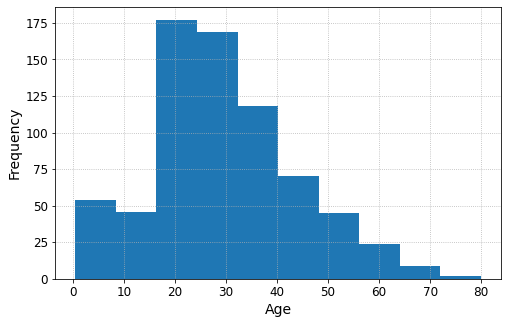

In [83]:
# Let's have a look on distributions.
plt.figure(figsize=(8, 5))
train_set["Age"].plot.hist()
plt.xlabel("Age")
plt.show()

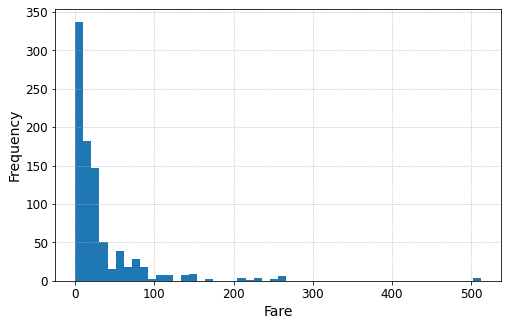

In [84]:
plt.figure(figsize=(8, 5))
train_set["Fare"].plot.hist(bins=50)
plt.xlabel("Fare")
plt.show()

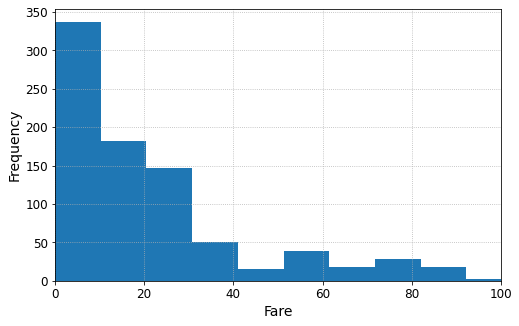

In [85]:
plt.figure(figsize=(8, 5))
train_set["Fare"].plot.hist(xlim=(0, 100), bins=50)
plt.xlabel("Fare")
plt.show()

**Sum up current observations:**
* Around 38% survived the disaster.
* More than 50% of the passengers travelled 3rd class. 
* Nearly 70% of passenger didn't have any relative on board.
* Male/Female ratio is 65/35.
* 50% of the passengers had 28 years old or less.
* Almost 350 passengers (from 891 in the train set) payed less than 10 dollars for a ticket, but some people payed nearly 500 dollars.

Now we can see the correlations and make some feature engineering. Probably good choices are `Pclass`, `Sex`, `Age` and `Fare`.

In [86]:
# Let's have a look on correlations.
corr = train_set.corr()
corr["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

We can see the higher the fare, the higher chance the passenger survived. Analogously for the class - passengers from 1st class had a higher chance to survive.

---

### **FEATURE ENGINEERING:**

In [87]:
for feature in ("Pclass", "Sex", "SibSp", "Parch", "Embarked"):
    print(train_set[["Survived", feature]].groupby([feature]).mean().sort_values(by="Survived", ascending=False))

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
        Survived
Sex             
female  0.742038
male    0.188908
       Survived
SibSp          
1      0.535885
2      0.464286
0      0.345395
3      0.250000
4      0.166667
5      0.000000
8      0.000000
       Survived
Parch          
3      0.600000
1      0.550847
2      0.500000
0      0.343658
5      0.200000
4      0.000000
6      0.000000
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957


In [88]:
# Make a copy for the case we break something down.
train_set_copy = train_set.copy()
test_set_copy = test_set.copy()

In [89]:
# Let's create a Age Bucket for different ranges of Age.
from scipy.stats import expon

train_set_copy["AgeBucket"] = pd.cut(train_set_copy["Age"],
                                     bins=[0, 3, 7, 12, 18, 25, 35, 50, np.inf],
                                     labels=[1, 2, 3, 4, 5, 6, 7, 8])
train_set_copy[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean().sort_values(by="AgeBucket")

,Survived
AgeBucket,
1,0.666667
2,0.700000
3,0.315789
4,0.428571
5,0.333333
6,0.423469
7,0.398693
8,0.343750


In [90]:
train_set_copy["AgeBucket"] = pd.cut(train_set_copy["Age"], 6, labels=[1, 2, 3, 4, 5, 6])

In [91]:
# Similarly, let's make a Fare Bucket.
train_set_copy["FareBucket"] = pd.cut(train_set_copy["Fare"], 10)
train_set_copy[["FareBucket", "Survived"]].groupby(["FareBucket"]).mean().sort_values(by="FareBucket")

,Survived
FareBucket,
"(-0.512, 51.233]",0.318306
"(51.233, 102.466]",0.660377
"(102.466, 153.699]",0.741935
"(153.699, 204.932]",1.000000
"(204.932, 256.165]",0.636364
"(256.165, 307.398]",0.666667
"(307.398, 358.63]",NaN
"(358.63, 409.863]",NaN
"(409.863, 461.096]",NaN


In [92]:
train_set_copy["FareBucket"] = pd.cut(train_set_copy["Fare"], 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [93]:
# Make a Relatives Bucket. We will create a new feature - IsAlone (indicating if the passenger was alone or had a family).
train_set_copy["RelativesBucket"] = train_set_copy["SibSp"] + train_set_copy["Parch"]
train_set_copy[["RelativesBucket", "Survived"]].groupby(["RelativesBucket"]).mean().sort_values(by="Survived", ascending=False)

,Survived
RelativesBucket,
3,0.724138
2,0.578431
1,0.552795
6,0.333333
0,0.303538
4,0.200000
5,0.136364
7,0.000000
10,0.000000


In [94]:
train_set_copy["IsAlone"] = (train_set_copy["RelativesBucket"] == 0).astype(int)
train_set_copy[["IsAlone", "Survived"]].groupby(["IsAlone"]).mean().sort_values(by="IsAlone")

,Survived
IsAlone,
0,0.505650
1,0.303538


In [95]:
# We can use the Name feature for extracting titles of passengers, due to the Name feature has a lot of unique values.
train_set_copy["Title"] = train_set_copy["Name"].str.extract(" ([A-Za-z]+)\.") # Extract only title e.g. "Miss".
train_set_copy["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [96]:
# Replace uniqe titles with "Unique".
unique_titles = set(train_set_copy["Title"]).difference({"Mr", "Miss", "Mrs", "Master"})
train_set_copy["Title"] = train_set_copy["Title"].replace(unique_titles, "Unique")
train_set_copy["Title"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Unique     27
Name: Title, dtype: int64

In [97]:
train_set_copy[["Title", "Survived"]].groupby(["Title"]).mean().sort_values(by="Title")

,Survived
Title,
Master,0.575000
Miss,0.697802
Mr,0.156673
Mrs,0.792000
Unique,0.444444


---

### **PREPROCESSING:**

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, add_age_bucket=True, add_fare_bucket=True, add_is_alone=True, add_title=True,
                remove_cabin=True, remove_ticket=True):
        self.add_age_bucket = add_age_bucket
        self.add_fare_bucket = add_fare_bucket
        self.add_is_alone = add_is_alone
        self.add_title = add_title
        self.remove_cabin = remove_cabin
        self.remove_ticket = remove_ticket
    
    def fit(self, X, y=None):
        self.age_median_ = X["Age"].median()
        self.fare_median_ = X["Fare"].median()
        self.most_frequent_embark_ = X["Embarked"].value_counts().index[0]
        return self

    def transform(self, X):
        X["Age"] = X["Age"].fillna(self.age_median_)
        X["Fare"] = X["Fare"].fillna(self.fare_median_)
        X["Embarked"] = X["Embarked"].fillna(self.most_frequent_embark_)
        if self.add_age_bucket:
            X["AgeBucket"] = pd.cut(X["Age"], 5, labels=[1, 2, 3, 4, 5])
            X.drop(["Age"], axis=1, inplace=True)
        if self.add_fare_bucket:
            X["FareBucket"] = pd.cut(X["Fare"], 5, labels=[1, 2, 3, 4, 5])
            X.drop(["Fare"], axis=1, inplace=True)
        if self.add_is_alone:
            X["IsAlone"] = (X["SibSp"] + X["Parch"] == 0).astype(int)
            X.drop(["SibSp", "Parch"], axis=1, inplace=True)
        if self.add_title:
            X["Title"] = X["Name"].str.extract(" ([A-Za-z]+)\.") # Extract only title e.g. "Miss".
            unique_titles = set(X["Title"]).difference({"Mr", "Miss", "Mrs", "Master"})
            X["Title"] = train_set_copy["Title"].replace(unique_titles, "Unique")
            X.drop(["Name"], axis=1, inplace=True)
        if self.remove_cabin:
            X.drop(["Cabin"], axis=1, inplace=True)
        if self.remove_ticket:
            X.drop(["Ticket"], axis=1, inplace=True)
        return X

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

attr_pipeline = Pipeline([
    ("attr_imputer_transformer", AttributeImputer()),
])

In [100]:
tmp_train_set = train_set.copy()
tmp_train_set = attr_pipeline.fit_transform(tmp_train_set)
tmp_train_set.head()

,PassengerId,Survived,Pclass,Sex,Embarked,AgeBucket,FareBucket,IsAlone,Title
0,1,0,3,male,S,2,1,0,Mr
1,2,1,1,female,C,3,1,0,Mrs
2,3,1,3,female,S,2,1,1,Miss
3,4,1,1,female,S,3,1,0,Mrs
4,5,0,3,male,S,3,1,1,Mr


In [101]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [102]:
from sklearn.compose import ColumnTransformer

cat_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, ["Pclass", "Sex", "Embarked", "AgeBucket", "FareBucket", "IsAlone", "Title"]),
])

preproc_pipeline = Pipeline([
    ("attrs_pipline", attr_pipeline),
    ("cats_pipeline", cat_pipeline),
])

In [103]:
tmp_train_set = train_set.copy()
tmp_train_set = tmp_train_set.set_index("PassengerId")
tmp_train_labels = tmp_train_set["Survived"]
tmp_train_set.drop("Survived", axis=1, inplace=True)
tmp_train_set = preproc_pipeline.fit_transform(tmp_train_set)

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

---

### **MODEL SELECTION:**

In [105]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(forest_clf, tmp_train_set, tmp_train_labels, cv=10)
forest_scores.mean()

0.7946566791510611

In [106]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_scores = cross_val_score(sgd_clf, tmp_train_set, tmp_train_labels, cv=10)
sgd_scores.mean()

0.7789388264669163

In [107]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_scores = cross_val_score(svm_clf, tmp_train_set, tmp_train_labels, cv=10)
svm_scores.mean()

0.8192883895131086

In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, tmp_train_set, tmp_train_labels, cv=10)
knn_scores.mean()

0.7935705368289638

In [109]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, tmp_train_set, tmp_train_labels, cv=10)
tree_scores.mean()

0.7912734082397004

In [110]:
# Looking for best parameters for Random Forest.
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid, cv=10, scoring="accuracy")
grid_search.fit(tmp_train_set, tmp_train_labels)
grid_search.best_score_

0.8047565543071162

In [111]:
# Looking for best parameters for SVM.
param_grid = [{
    "C": [0.3, 1, 3],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}]

svm_clf = SVC(random_state=42)
grid_search = GridSearchCV(svm_clf, param_grid, cv=10, scoring="accuracy")
grid_search.fit(tmp_train_set, tmp_train_labels)
grid_search.best_score_

0.8215605493133582

In [112]:
grid_search.best_params_

{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_rnd = {  # gamma is ignored when kernel is "linear"
    "kernel": ["linear", "rbf", "poly"],
    "C": reciprocal(0.2, 200),
    "gamma": expon(scale=1.),
}

rnd_search = RandomizedSearchCV(
    SVC(),
    param_distributions=param_rnd,
    n_iter=50,
    scoring="accuracy",
    random_state=42,
    cv=5
)
rnd_search.fit(tmp_train_set, tmp_train_labels)
rnd_search.best_score_

0.8148389931579938

In [114]:
rnd_search.best_params_

{'C': 5.220051301226952, 'gamma': 0.1273723936155019, 'kernel': 'rbf'}

In [115]:
svm_final = SVC(random_state=42, **grid_search.best_params_)
svm_final.fit(tmp_train_set, tmp_train_labels)

SVC(C=3, random_state=42)

---

### **FINAL PREDICTIONS:**

In [117]:
tmp_test_set = test_set.copy()
idx = tmp_test_set["PassengerId"]
tmp_test_set = tmp_test_set.set_index("PassengerId")
tmp_test_set = preproc_pipeline.transform(tmp_test_set)

results = svm_final.predict(tmp_test_set)
df = pd.DataFrame({"PassengerId": idx, "Survived": results})
df.set_index("PassengerId").to_csv("data/submission.csv")
df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
